The notebook contains three ML models for landslide susceptibility mapping: Random Forest (RF), Logistic Regression (LR) and Support Vector Machine (SVM) with the Predictor set II that includes climate variables (Predictor Set II)

In [1]:
from pyspatialml import Raster
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import seaborn as sn
import rasterio.plot
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Setting up the working directory:

In [2]:
os.chdir(r'C:\Users\aageen17\Desktop\Variables')

Loading the preprocessed landslide presence/absebce points

In [3]:
data=pd.read_csv('data_final.csv')

In [4]:
data.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,average_temp_ref,cloudburst_ref,groundwater_ref,rain_average_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary,class
0,15.706318,4.440497,0.126874,0.173688,-1.667908,0.196570,-0.980490,4.752529,115.0,300.0,8.462731,0.332363,-8.441628,2.006541,33.681606,15.0,7.0,3.0,6.0,1
1,15.232349,3.427183,0.048178,0.395249,0.731700,0.575379,-0.817887,3.343206,52.0,300.0,8.462731,0.332363,-1.949753,2.006541,33.681606,15.0,7.0,3.0,6.0,1
2,17.030214,3.888671,-0.000931,0.361396,1.081142,0.634705,-0.772755,0.880331,80.0,300.0,8.462731,0.332363,-1.608266,2.006541,33.681606,15.0,7.0,3.0,6.0,1
3,15.583941,4.675134,-0.030232,0.183543,0.294679,-0.788825,-0.614618,3.459515,120.0,300.0,8.455420,0.329927,-7.234321,2.017731,33.668327,15.0,7.0,3.0,6.0,1
4,17.499943,8.491714,0.150789,0.410609,5.817518,0.268115,-0.963387,2.392220,89.0,300.0,8.463237,0.328551,-0.485680,2.021318,33.706505,15.0,7.0,3.0,6.0,1


In [5]:
predictors =['dem_elevation.tif', 'TWI.tif', 'TPI.tif', 'TRI.tif', 'SPI.tif', 'easterness.tif', 'northerness.tif', 'slope_std.tif',  'distance_coast.tif', 'distance_streams.tif', 'average_temp_ref.tif', 'cloudburst_ref.tif', 'groundwater_ref.tif', 'rain_average_ref.tif', 'rain_max_day_ref.tif','soil.tif', 'geomorphology.tif', 'underground.tif', 'prequaternary.tif']

In [6]:
stack = Raster(predictors)

In [7]:
stack.names

dict_keys(['dem_elevation', 'TWI', 'TPI', 'TRI', 'SPI', 'easterness', 'northerness', 'slope_std', 'distance_coast', 'distance_streams', 'average_temp_ref', 'cloudburst_ref', 'groundwater_ref', 'rain_average_ref', 'rain_max_day_ref', 'soil', 'geomorphology', 'underground', 'prequaternary'])

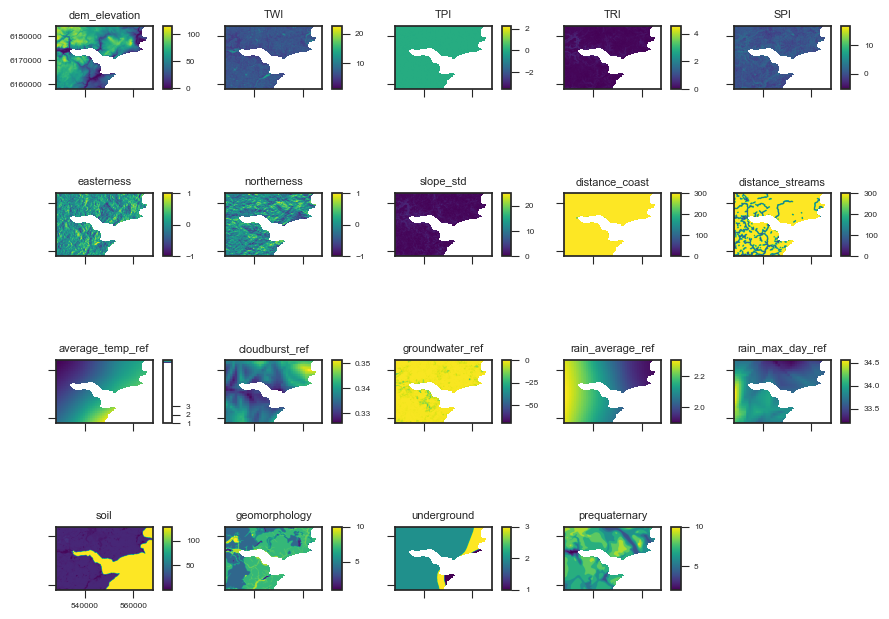

In [8]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

Importing packages for Machine Learning

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, KFold

In [10]:
soil_idx = list(stack.names).index("soil")
geomorphology_idx = list(stack.names).index("geomorphology")
underground_idx = list(stack.names).index("underground")
prequaternary_idx = list(stack.names).index("prequaternary")
print(soil_idx, geomorphology_idx, underground_idx, prequaternary_idx)

15 16 17 18


In [11]:
#index of categorical features from the dataset
categorical_features = [15, 16, 17, 18] # 'soil', 'geomorphology', 'underground', 'prequarternary'

In [12]:
#index of numerical features from the dataset
numerical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

In [13]:
preprocessor = ColumnTransformer([
    ('ohe_soil', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)])

In [14]:
X = data.loc[:, stack.names]

Printing the first three rows 

In [15]:
X[:3]

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,average_temp_ref,cloudburst_ref,groundwater_ref,rain_average_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary
0,15.706318,4.440497,0.126874,0.173688,-1.667908,0.196570,-0.980490,4.752529,115.0,300.0,8.462731,0.332363,-8.441628,2.006541,33.681606,15.0,7.0,3.0,6.0
1,15.232349,3.427183,0.048178,0.395249,0.731700,0.575379,-0.817887,3.343206,52.0,300.0,8.462731,0.332363,-1.949753,2.006541,33.681606,15.0,7.0,3.0,6.0
2,17.030214,3.888671,-0.000931,0.361396,1.081142,0.634705,-0.772755,0.880331,80.0,300.0,8.462731,0.332363,-1.608266,2.006541,33.681606,15.0,7.0,3.0,6.0


Our labels

In [16]:
y = data["class"]

In [17]:
y[:3]

0    1
1    1
2    1
Name: class, dtype: int64

Splitting our data into a training (70% of the data) and a testing set (30%), stratified after classes, so that we get the same amount of landslide and non-landslide samples in both sets. Random_sate= 42 for reproducebility

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Checking the number of points in testing and training data

In [19]:
X_train.shape

(634, 19)

In [20]:
X_test.shape

(272, 19)

In [21]:
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

## Random Forest model

In [22]:
# Create the  grid for hyperparametertuning
grid_rf = {'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400],
           'classifier__max_features': ['auto', 'sqrt', 'log2']}
print(grid_rf)

{'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400], 'classifier__max_features': ['auto', 'sqrt', 'log2']}


In [24]:
# Create a classifier
rf = RandomForestClassifier(random_state=42)

In [25]:
rf_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', rf)
])

In [26]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model_rf = GridSearchCV(rf_flow, param_grid = grid_rf, cv = kfold, scoring=acc_scorer)

Fitting the grid search to our training data

In [27]:
model_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

Best parameters from the grid search

In [28]:
model_rf.best_params_

{'classifier__max_features': 'log2', 'classifier__n_estimators': 200}

In [29]:
y_pred_rf = model_rf.predict(X_test)

Using the testing data for prediction

In [30]:
y_pred_rf = model_rf.predict(X_test)

Printing classification report

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.93      0.90      0.92       136
    landslide       0.91      0.93      0.92       136

     accuracy                           0.92       272
    macro avg       0.92      0.92      0.92       272
 weighted avg       0.92      0.92      0.92       272



Printing confusion matrix

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))

[[123  13]
 [  9 127]]


Doing it in a better visual way

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

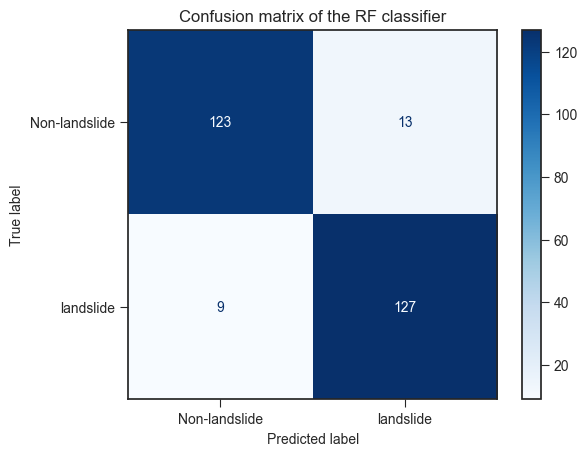

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

Printing overall accuracy (all the correctly classified samples divided by the total number of samples)

In [35]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf))

0.9191176470588235


Checking how our model is different from a classification created by a random process

In [36]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred_rf))

0.8382352941176471


Plotting ROC - Area Under the Curve

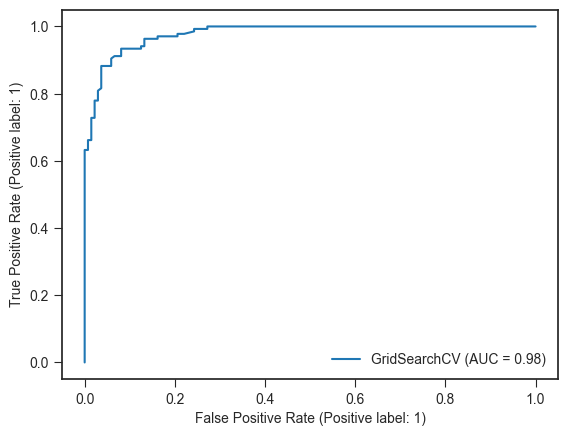

In [43]:
from sklearn import metrics
from sklearn.metrics import roc_curve

metrics.plot_roc_curve(model_rf, X_test, y_test)  
plt.show() 

## Support Vector Machine model

In [37]:
from sklearn.svm import SVC

Creating the parameter grid we want to search through in order to find an optimal set of parameters for SVM

In [38]:
param_grid_SVM =[
  {'classifier__C': [0.001, 0.1, 1, 10], 'classifier__gamma': [1, 0.1, 0.01,0.001, 0.0001, 'scale', 'auto'], 'classifier__kernel': ['rbf']},
 ]

In [39]:
# Create a model
svm = SVC(probability=True, random_state=42)

svm_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', svm)
])

# Instantiate the grid search model with 10-fold cross-validation
inner = KFold(n_splits=10, shuffle=True, random_state=42)
model_svm = GridSearchCV(svm_flow, param_grid = param_grid_SVM, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_svm.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

In [40]:
model_svm.best_params_

{'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}

In [41]:
model_svm.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

Predicting classes on the testing data

In [42]:
y_pred_svm = model_svm.predict(X_test)

Plotting confusion matrix

In [43]:
print(classification_report(y_test, y_pred_svm, target_names = ['non-landslide', 'landslide']))


               precision    recall  f1-score   support

non-landslide       0.94      0.90      0.92       136
    landslide       0.90      0.94      0.92       136

     accuracy                           0.92       272
    macro avg       0.92      0.92      0.92       272
 weighted avg       0.92      0.92      0.92       272



In [44]:
print(accuracy_score(y_test, y_pred_svm))

0.9191176470588235


In [45]:
print(cohen_kappa_score(y_test, y_pred_svm))

0.8382352941176471


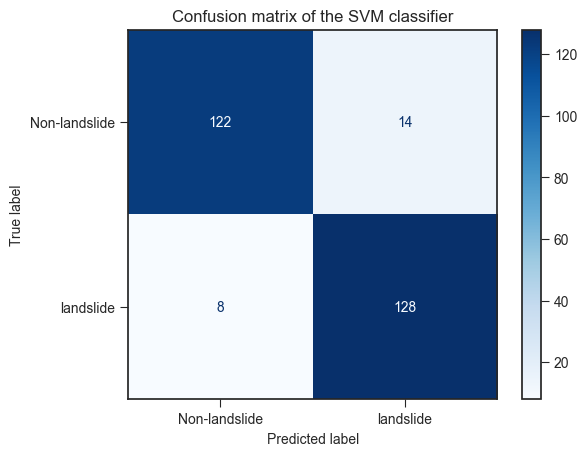

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

Plotting ROC curve

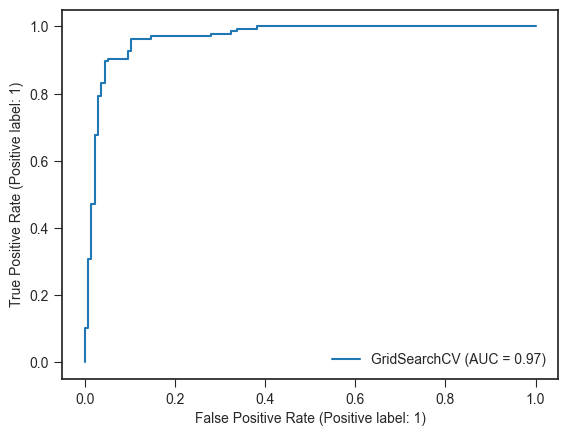

In [55]:
metrics.plot_roc_curve(model_svm, X_test, y_test)  
plt.show() 

## Logistic Regression model

In [47]:
from sklearn.linear_model import LogisticRegression

Creating the parameter grid we want to search through in order to find an optimal set of parameters for LR

In [48]:
param_grid_lr = [
  {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1','l2']},
  {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2']},
 ]

In [49]:
lr = LogisticRegression(random_state=42) 
# Instantiate the grid search model

lr_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', lr)
])

# Instantiate the grid search model with 10-fold cross-validation
model_lr = GridSearchCV(lr_flow, param_grid = param_grid_lr, cv = inner, scoring=acc_scorer)


# Fit the grid search to the data
model_lr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

In [50]:
model_lr.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [51]:
model_lr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('ohe_soil',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                       

Predicting on the test data

In [52]:
y_pred_lr = model_lr.predict(X_test)

Plotting the confusion matrix

In [53]:
print(classification_report(y_test, y_pred_lr, target_names = ['non-landslide', 'landslide']))

               precision    recall  f1-score   support

non-landslide       0.94      0.90      0.92       136
    landslide       0.90      0.94      0.92       136

     accuracy                           0.92       272
    macro avg       0.92      0.92      0.92       272
 weighted avg       0.92      0.92      0.92       272



In [54]:
round(accuracy_score(y_test, y_pred_lr), 4)

0.9191

In [55]:
print(cohen_kappa_score(y_test, y_pred_lr))

0.8382352941176471


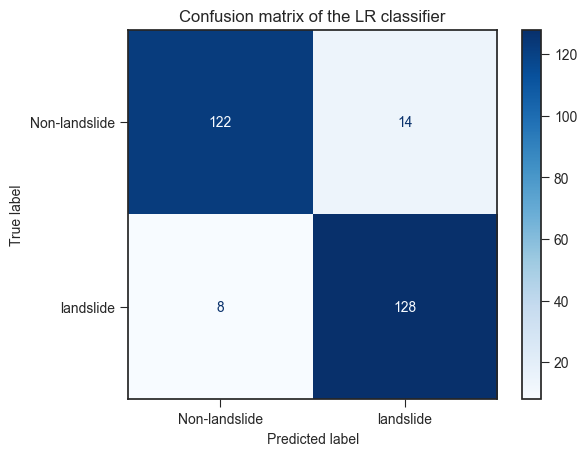

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

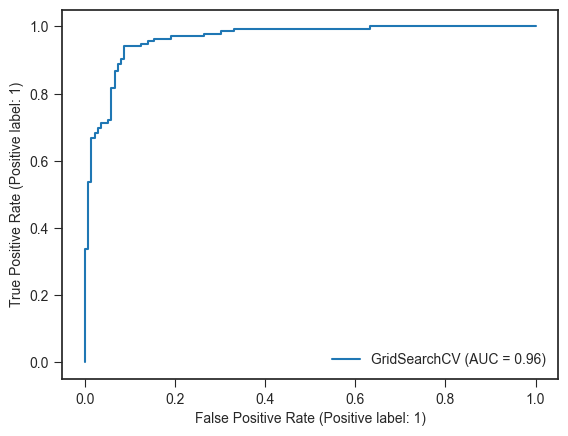

In [68]:
metrics.plot_roc_curve(model_lr, X_test, y_test)  
plt.show() 

## Plotting ROC curves for the three models for comparison

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

The code below does the same as plotting of individual roc curves, as seen before

In [70]:
pred_prob_rf=model_rf.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob_rf, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc1 = auc(fpr1, tpr1)

In [71]:
pred_prob_svm=model_svm.predict_proba(X_test)[:,1]
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_prob_svm, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc2 = auc(fpr2, tpr2)

In [72]:
pred_prob_lr=model_lr.predict_proba(X_test)[:,1]
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_prob_lr, pos_label=1)
roc_auc3 = auc(fpr3, tpr3)

Plotting the three curves in one graph

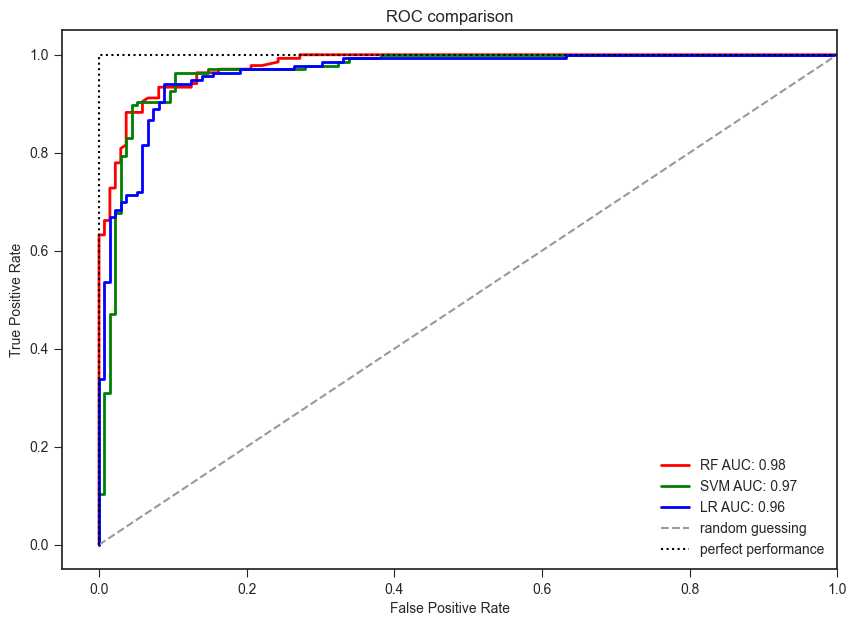

In [73]:
# AUC score that summarizes the ROC curve
f, ax = plt.subplots(figsize=(10,7))
plt.plot(fpr1,tpr1, color ='red', lw=2, label= 'RF AUC: {:.2f}'.format(roc_auc1))
plt.plot(fpr2,tpr2, color ='green', lw=2, label='SVM AUC: {:.2f}'.format(roc_auc2))
plt.plot(fpr3,tpr3, color ='blue', lw=2, label='LR AUC: {:.2f}'.format(roc_auc3))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison')
plt.legend(loc="lower right")

#plt.savefig(r'C:\Users\aageen17\Desktop\figures\AUC.png', bbox_inches='tight')
plt.show()




## External Validation on the dataset outside of our AOI

Reading the data (landslide absence and presence points). The data is unseen by the models, as it comes outside of the AOI, and it has not earlier been used for training or testing

In [58]:
external_val_data=pd.read_csv(r"C:\Users\aageen17\Desktop\external_validation\sample_points_external_validation.csv")

Dividing the data into variables and the labels

In [59]:
X_val = external_val_data.iloc[:, 0:-1]

In [60]:
X_val.head()

,dem_elevation,TWI,TPI,TRI,SPI,easterness,northerness,slope_std,distance_coast,distance_streams,average_temp_ref,cloudburst_ref,groundwater_ref,rain_average_ref,rain_max_day_ref,soil,geomorphology,underground,prequaternary
0,49.812370,0.083854,-0.003757,0.129422,0.260900,0.996409,-0.084667,0.260900,300.0,300.0,8.714708,0.344714,-1.862408,2.357941,36.355110,13.0,7.0,2.0,6.0
1,49.604942,0.046702,-0.015270,0.073316,0.098046,-0.840527,-0.541769,0.098046,300.0,300.0,8.715714,0.345622,-2.198076,2.336368,35.777359,15.0,7.0,2.0,3.0
2,5.504304,0.015311,0.001757,0.025309,0.187640,0.305586,0.952165,0.187640,300.0,170.0,8.960491,0.348792,-0.754028,1.935387,32.383217,15.0,7.0,3.0,5.0
3,14.678636,0.020014,0.082338,0.082340,1.015810,0.167411,0.985887,1.015810,300.0,300.0,8.940946,0.340399,-0.766196,2.000846,32.761238,15.0,7.0,2.0,3.0
4,49.577496,0.015639,0.011391,0.023651,0.299227,0.997049,0.076766,0.299227,300.0,300.0,8.512472,0.338073,-3.730066,2.325771,34.447304,13.0,1.0,2.0,7.0


In [61]:
y_val = external_val_data["class"]

## SVM

Predicting classes with SVM. The pipeline first transforms the features with the fitted StandardScaler and then performes the binary classification

In [62]:
y_pred_svm_val = model_svm.predict(X_val)

Overall accuracy score

In [63]:
round(accuracy_score(y_val, y_pred_svm_val),4)

0.6586

Confusion matrix

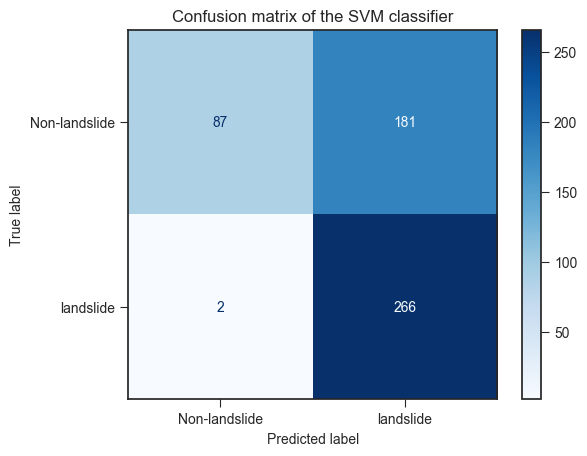

In [64]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_svm_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the SVM classifier')
plt.show()

## Random Forest

In [65]:
y_pred_rf_val = model_rf.predict(X_val)

In [66]:
round(accuracy_score(y_val, y_pred_rf_val), 4)

0.959

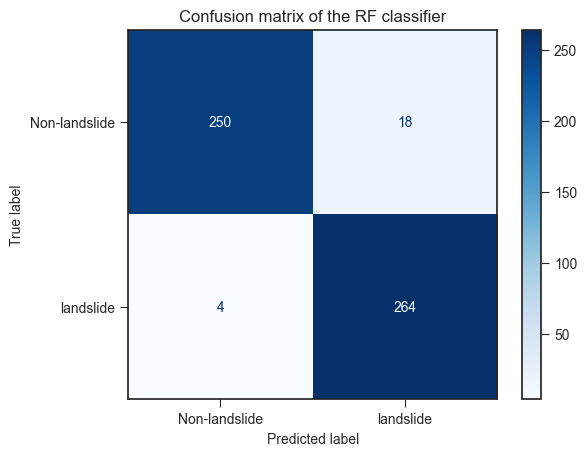

In [67]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

## Logistic Regression

In [68]:
y_pred_lr_val = model_lr.predict(X_val)

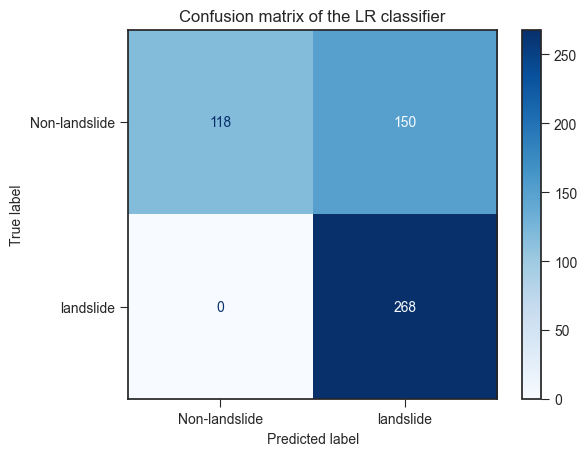

In [69]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr_val, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the LR classifier')
plt.show()

In [70]:
round(accuracy_score(y_val, y_pred_lr_val), 4)

0.7201

## Making susceptibility maps with our trained classifiers

In [114]:
predictors_present = stack

Predicting class probability. The pipeline first transforms the data according to the StandardScaler and One-Hot encoding fitted on the training data, and then performs the classification, where the output is the probability of a pixel belonging to a certain class (landslide/non-landslide)

In [92]:
result_present_rf = predictors_present.predict_proba(model_rf)

Plotting probabilities

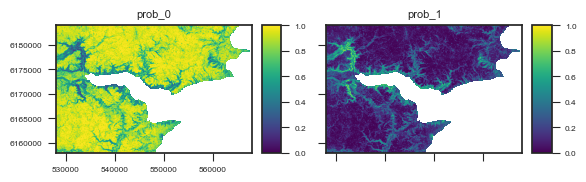

In [93]:
result_present_rf.plot()
plt.show()

Saving the result as a .tif file

In [94]:
result_present_rf.write(r"probability_rf_present_with_climate.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_rf_present_with_climate.tif, prob...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Repeating it with LR

In [95]:
result_present_lr = predictors_present.predict_proba(model_lr)

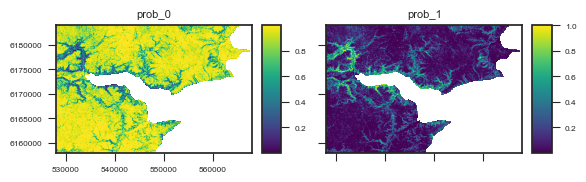

In [96]:
result_present_lr.plot()
plt.show()

In [97]:
result_present_lr.write(r"probability_lr_present_with_climate.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_lr_present_with_climate.tif, prob...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


and SVM

In [116]:
result_present_svm = predictors_present.predict_proba(model_svm)

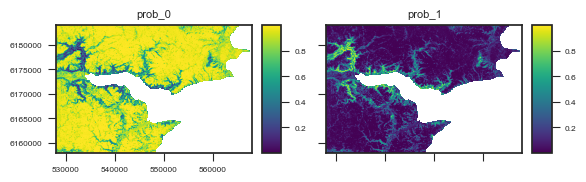

In [117]:
result_present_svm.plot()
plt.show()

In [118]:
result_present_svm.write(r"probability_svm_present_with_climate.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_svm_present_with_climate.tif, pro...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


## Making susceptibility maps (future scenario) with our trained classifiers

For the future prections the variables 'groundwater', 'rain_average, 'rain_max_day', 'average_temp_ref', 'distance_coast' are susbstituted with the future predictions for RCP8.5 2071-2200, while the rest of the variables is assumed to stay unchanged. The trained classifiers are then used to predict probabilities for each class (landslide/non-landslide)

In [99]:
os.chdir(r'C:\Users\aageen17\Desktop\Variables_future')

In [100]:
predictors_future =['dem_elevation.tif', 'TWI.tif', 'TPI.tif', 'TRI.tif', 'SPI.tif', 'easterness.tif', 'northerness.tif', 'slope_std.tif',  'distance_coast.tif', 'distance_streams.tif', 'average_temp_ref.tif', 'cloudburst_ref.tif', 'groundwater_ref.tif', 'rain_average_ref.tif', 'rain_max_day_ref.tif', 'soil.tif', 'geomorphology.tif', 'underground.tif', 'prequaternary.tif']

In [101]:
stack_future = Raster(predictors_future)

Random Forest

In [102]:
result_future_rf = stack_future.predict_proba(estimator=model_rf)

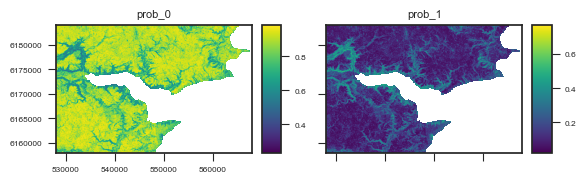

In [103]:
result_future_rf.plot()
plt.show()

In [104]:
result_future_rf.write(r"probability_rf_future.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_rf_future.tif, probability_rf_fut...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Logistic Regression

In [105]:
result_future_lr = stack_future.predict_proba(model_lr)

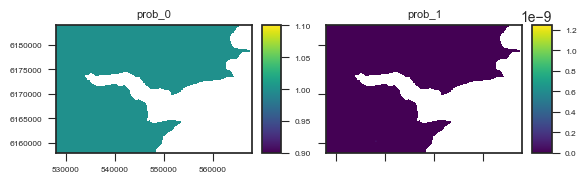

In [106]:
result_future_lr.plot()
plt.show()

In [107]:
result_future_lr.write(r"probability_lr_future.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_lr_future.tif, probability_lr_fut...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Support Vector Machine

In [108]:
result_future_svm = stack_future.predict_proba(model_svm)

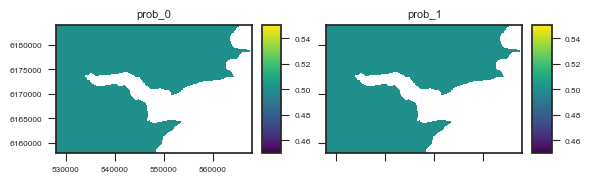

In [109]:
result_future_svm.plot()
plt.show()

In [110]:
result_future_svm.write(r"probability_svm_future.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_svm_future.tif, probability_svm_f...
2        rows                                              13000
3        cols                                              19976
4         res                          (2.0000000000000444, 2.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...
